In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
import src.CayleyNet as CayleyNet
import src.CORA as CORA
import src.utils as utils

In [4]:
# Reload when files are changed
import importlib
importlib.reload(CayleyNet)
importlib.reload(CORA)
importlib.reload(utils)

<module 'src.utils' from '/home/infres/avalenca-22/CayleyNets/src/utils.py'>

In [5]:
# Import dataset
cora = CORA.CORA()

Parsing files...
Done.


In [6]:
# Print properties of the dataset
dataset = cora
print(dataset.description)
print(f'Number of nodes: {dataset.n}')
print(f'Number of edges: {dataset.n_edges}')
print(f'Number of features per node: {dataset.n_features}')

CORA dataset
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433


In [7]:
# Extended split of the CORA dataset
train_mask, test_mask, val_mask = utils.split_train_test_val(dataset.n, 500, 500) 

In [8]:
# Features and labels as tensors
features = torch.Tensor(1.0*dataset.features).to(device)
labels = torch.Tensor(dataset.labels).long().to(device)
edge_index = dataset.get_edge_index().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

In [9]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 16
n_hidden_layers = 1 # number of hidden layers
r = 5 # Cayley polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper

In [10]:
p_dropout=0.5
normalization = 'sym'
model = CayleyNet.CayleyNet(in_feats, n_classes, n_hidden, n_hidden_layers, r=r, p_dropout=p_dropout, normalization=normalization, sparse=False, seed=0)

/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1133: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [11]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')           

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1433, 16, r=5, normalization=sym)
    (1): CayleyConv(16, 7, r=5, normalization=sym)
  )
)
Number of parameters: 23042
Number of parameters: 22929
Number of parameters: 113


In [12]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [13]:
# Train the model
batch_size = 32
epochs = 200

# save loss values for plotting
loss_values = []
val_score = []
train_score = []

verbose = True
for e in range(epochs):
    start = time.time()

    # Compute output
    logp = model(features, edge_index)

    # Compute loss
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    loss_values.append(loss.item())

    # Perform backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, train_mask)
    train_score.append(score)

    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, val_mask)
    val_score.append(score)

    # Print loss
    end = time.time()
    if verbose:
        print("Epoch {:02d} | Loss {:.3f} | Accuracy (validation) {:.3f} | Elapsed time: {:.2f}s".format(e, loss.item(), score, end - start))

Epoch 00 | Loss 2.118 | Accuracy (validation) 0.154 | Elapsed time: 2.09s
Epoch 01 | Loss 1.947 | Accuracy (validation) 0.180 | Elapsed time: 1.54s
Epoch 02 | Loss 1.859 | Accuracy (validation) 0.230 | Elapsed time: 1.54s
Epoch 03 | Loss 1.785 | Accuracy (validation) 0.256 | Elapsed time: 1.54s
Epoch 04 | Loss 1.718 | Accuracy (validation) 0.278 | Elapsed time: 1.54s
Epoch 05 | Loss 1.653 | Accuracy (validation) 0.306 | Elapsed time: 1.54s
Epoch 06 | Loss 1.587 | Accuracy (validation) 0.330 | Elapsed time: 1.54s
Epoch 07 | Loss 1.520 | Accuracy (validation) 0.354 | Elapsed time: 1.54s
Epoch 08 | Loss 1.453 | Accuracy (validation) 0.376 | Elapsed time: 1.54s
Epoch 09 | Loss 1.384 | Accuracy (validation) 0.406 | Elapsed time: 1.54s
Epoch 10 | Loss 1.314 | Accuracy (validation) 0.424 | Elapsed time: 1.54s
Epoch 11 | Loss 1.243 | Accuracy (validation) 0.450 | Elapsed time: 1.54s
Epoch 12 | Loss 1.173 | Accuracy (validation) 0.482 | Elapsed time: 1.54s
Epoch 13 | Loss 1.104 | Accuracy (vali

In [14]:
test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.760


In [15]:
results = {'model': 'CayleyNet',
           'dataset': dataset.name,
           'training size': len(train_mask),
           'validation size': len(val_mask),
           'test size': len(test_mask),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'batch size': batch_size,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

In [16]:
import pickle
import datetime
ts = datetime.datetime.now()
ts = '{}-{}-{}-{}-{}-{}'.format(ts.year, ts.month, ts.day, ts.hour, ts.minute, ts.second)
fname = './results/cayley_{}.pkl'.format(ts)
with open(fname, 'wb') as f:
    pickle.dump(results, f)
        
with open(fname, 'rb') as f:
    loaded_results = pickle.load(f)

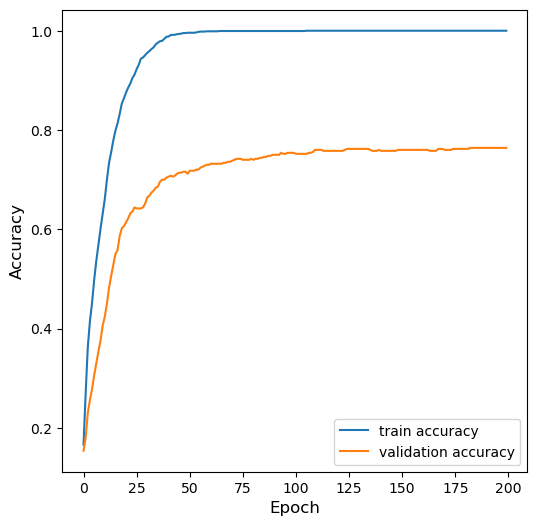

In [17]:
utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])

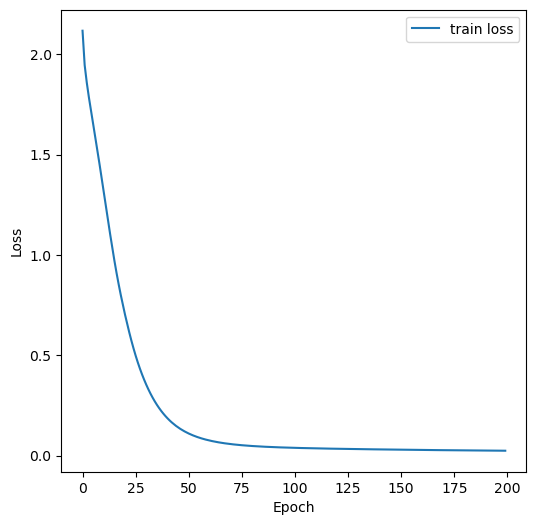

In [18]:
utils.plot_loss(loaded_results['loss'])

In [19]:
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))

Test accuracy 0.760


# CayLeyNet for community detection

In [1]:
import src.CommunitiesGraph as CG
import numpy as np

ModuleNotFoundError: No module named 'sknetwork'

In [2]:
n_community=15
p=0.5
q=0.001
n=1000
graph = CG.CommunitiesGraph(n_community, p, q, n)

Adj = graph.adjacency
edge_index = torch.tensor(np.array(Adj.nonzero()), dtype=torch.long).to(device) 

NameError: name 'CG' is not defined

In [3]:
# Generation of noisy steps signals s.t. f^j_i = 1 + sigma if i in cluster j and f^j_i = sigma if i not in cluster j
f = torch.zeros((n_community, n))
labels = graph.label


for i in range(n_community):
    for j in range(n):
        if labels[j] == i:
            f[i, j] = 1 + np.random.normal(0, 0.3)
        else:
            f[i, j] = np.random.normal(0, 0.3)

f = f.to(device)
print(f.device)

NameError: name 'torch' is not defined

In [4]:
# Hyperparameters

hidden_channels = 32
feature_channels = 1
r = 10
jacobi_iters = 5
sparse = False
dropout = 0.5
normalization = 'sym'
bias = True

model = CayleyNet.CayleyNet(in_feats= feature_channels, n_classes = n_community, n_hidden = hidden_channels, n_layers=1, r = r, p_dropout=dropout, normalization=normalization, sparse=sparse)

NameError: name 'CayleyNet' is not defined

In [5]:
importlib.reload(CayleyNet)
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

NameError: name 'importlib' is not defined

In [6]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

label = torch.tensor(np.arange(n_community)).long()

# train the model
for epoch in range(100):
    optimizer.zero_grad()
    for j in range(n_community):
        out = model(f[j], edge_index)
        loss = criterion(out, label[j])
        loss.backward()
        optimizer.step()
        
        
    print('Epoch %d | Loss: %.4f' % (epoch+1, loss.item()))

NameError: name 'model' is not defined